# Project 1: Analyzing Spectroscopic data from OMM

By: Michael Jafs


Module Imports..

In [58]:
import os
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from astropy.utils.data import download_file
from scipy.stats import lognorm
from astropy.wcs import WCS
import astropy.units as u
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

#scale the size of following 2D plots of the various fits files
plt.rcParams['figure.figsize'] = (12, 2)

## Part 1: Exploration

Anticipating needing plotting functionality for opening and visualizing the fits files I will define a couple small functions right away.

In [5]:
def plot_fits(data, vmin, vmax, title, norm = None):
    """
    Function used to short-cut plotting the 2D fits files
    :param data: Fits file data
    :param vmin: Minimum value for the heatmap
    :param vmax: Maximum value for the heatmap
    :param title: Title of the heatmap
    :param norm: The scaling used for the heatmap
    :return: None
    """
    fig, ax = plt.subplots()
    im = ax.imshow(data, vmin=vmin, vmax=vmax, cmap='viridis', origin='lower', norm=norm, aspect='auto')
    ax.set_xlabel('x pixels', fontsize = 13)
    ax.set_ylabel('y pixels', fontsize = 13)
    ax.set_title(title)
    fig.colorbar(im)

def fits_to_data(file_name):
    """
    Small function that combines the step of opening the fits file and
    separating out the file object from the data itself in a single line.
    :param file_name: Fits file to open
    :return: 2D data and file object used, for instance, for printing the header
    """
    source_file = fits.open(file_name)
    source_data = source_file[0].data
    return source_data, source_file


We can begin the exploration by visualizing the source and calibration files and one of the dark frames.

In [6]:
#variable file names
parent = './fit_files/'
bias = './bias/'
dark = './dark/'
flat = './flat/'
source_fits = parent + 'source.fits'
cal_lamp_fits = parent + 'calibration.fits'
bias_frame_fits = parent + bias + 'bias0008.fits'
dark_frame_fits = parent + dark + 'dark0001.fits'

#retrieve both the data and HDUList objects for the source, calibration lamp, one bias, and one dark frame
s_data, s_file = fits_to_data(source_fits)
cal_lamp_data, cal_lamp_file = fits_to_data(cal_lamp_fits)
bias_frame_data, bias_frame_file = fits_to_data(bias_frame_fits)
dark_frame_data, dark_frame_file = fits_to_data(dark_frame_fits)

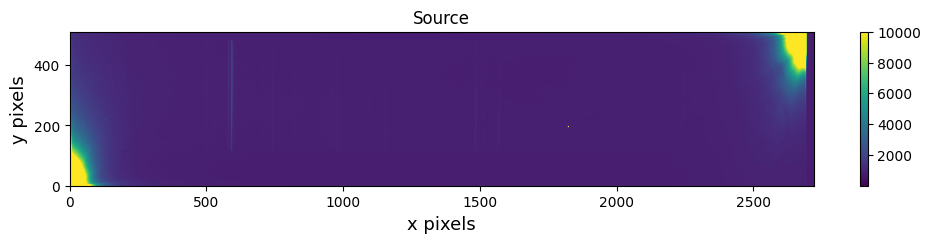

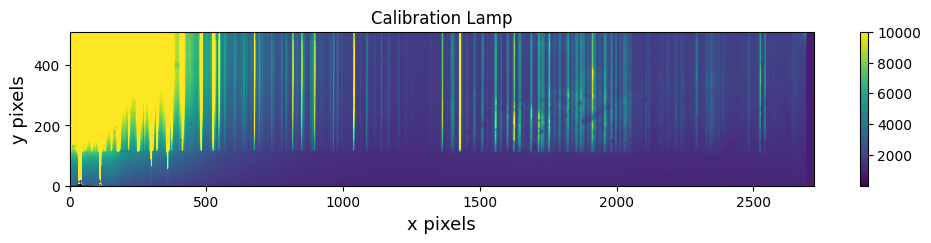

In [14]:
#Now let's plot the different images:

#Modifying the scale for the source and calibration lamp seems to bring out a few of the features
vmin = 1e1
vmax = 1e4

plot_fits(s_data, vmin, vmax, title='Source', norm=None)
plot_fits(cal_lamp_data, vmin, vmax, title='Calibration Lamp', norm=None)


The source file seems to be dominated by two bright patches in the upper right and lower left part of the 2D spectrum which could indicate a slight tilt of the spectrograph relative to the plane of observation. This "rotation" of the spectrograph could be a large systematic since it could result in spectral lines appearing offset from their true location. Fortunately, there does seem to be a small vertical strip free of significant saturation on either side of the plot. The calibration lamp on the other hand shows many distint spectral lines, however it seems to suffer from a large amount of saturation on the left hand side that may be difficult to clean.

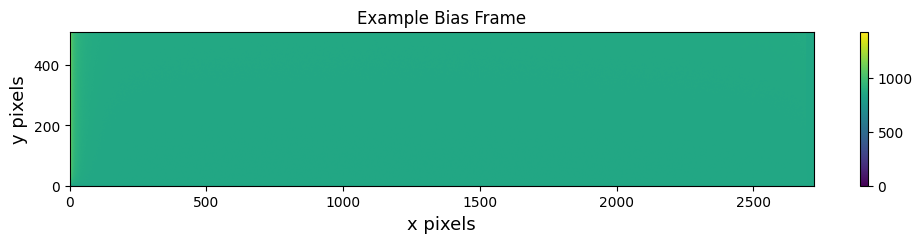

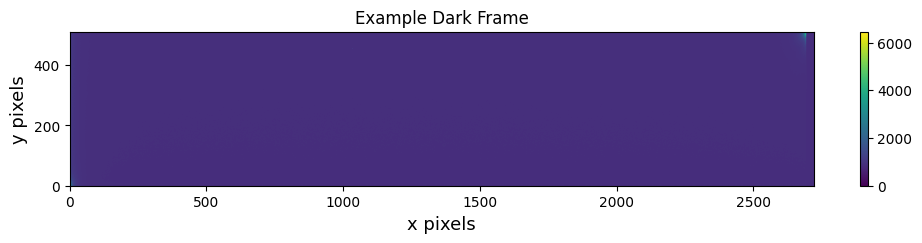

In [13]:
plot_fits(bias_frame_data, vmin, vmax, title='Example Bias Frame', norm=None)
plot_fits(dark_frame_data, vmin, vmax, title='Example Dark Frame', norm=None)

Both the bias and the dark frames are free from any discernible spectral lines or notable features, which corresponds with what we expect from these frames. Interestingly, there is a small amount of signal in the upper right corner of the dark frame which is likely due to thermal noise of the CCD.

At this point, we can read out the header of the source file to see what we're dealing with.

In [15]:
source_header = s_file[0].header
print(repr(source_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'orion   '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'object  '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:21:

 [astropy.io.fits.verify]


Based on the header information, the object of the observation was the Orion nebula.

In a CCD, the physical processes (essentially electron movement) within the instrument will result in noise that is also picked up by the CCD. This means that even without the presence of a light source, we still expect a small amount of noise picked up by the CCD. This could explain the small amount of pixels lit up in the dark frame plotted above.

#### 1D Spectrum conversion

Taking another look at the 2D source file plotted above, it seems that the image is relatively free of thermal noise in a vertical range of 180 - 200 pixels and a horizontal range of about 300 - 1800 pixels. Let's view this spectrum quickly before moving on to cleaning the images.

Text(0, 0.5, 'Total Counts')

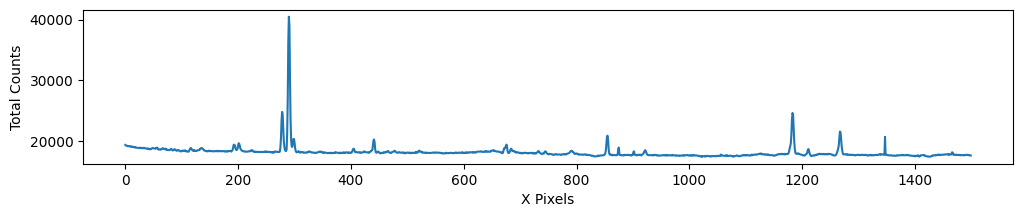

In [21]:
source_spectrum = np.sum(s_data[180:200, 300:1800], axis = 0)

plt.plot(source_spectrum)
plt.xlabel("X Pixels")
plt.ylabel("Total Counts")

## Part 2: Noise Removal

### Part 2.1 - Master Bias

For the first step of the noise removal, we need to make a master bias frame by taking the median of all the bias frames included. A bias frame is a minimum duration exposure taken without significant light entering the detector. A bias frame is essentially a dark frame frame taken with the fastest shutter speed available. As such, they are used to subtract the average readout noise (the noise present everytime the sensor reads the pixel data) from the frames of the actual data.

In [24]:
#incase there are extra bias files with different file names
directory = r"./fit_files/bias/"
bias_frames = []

#make sure we are only using the correct files
for name in os.listdir(directory):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        # print(name)
        bias_frames.append(name)

#construct the bias frame array
bias_data = []
bias_files = []
for fit_file in bias_frames:
    # print(fit_file)
    file_name = directory + fit_file
    # print(file_name)
    data, file = fits_to_data(directory + str(fit_file))
    bias_data.append(data)
    bias_files.append(file)

#find the median bias frame
bias_array = np.zeros((bias_data[0].shape[0], bias_data[0].shape[1], len(bias_data)))
for num, data_file in enumerate(bias_data):
    bias_array[:, :, num] = data_file
median_bias = np.median(bias_array, axis = 2)

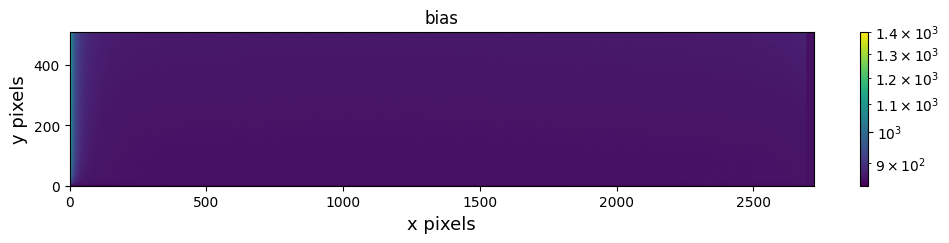

In [25]:
#Visualizing the resulting frame
vmin = None
vmax = None
norm = "log"
plot_fits(median_bias, vmin=vmin, vmax=vmax, title="bias", norm=norm)

The resulting frame seems to be mostly consistent with what the bias is trying to correct for in that it should only be detecting read noise from the CCD. The frame is therefore mostly consistent with a small amount of noise on the left side of the plot, similar to where the source and calibration files were dominated by noise.

I will begin the noise removal process by subtracting the bias from the source, calibration, dark, and flat frames.

In [26]:
#we have the source data file from before (it's just s_data)

#Unpacking the other files:
#This block of code was necessary since there seemed to be a set of dark, flat and bias files with different file names. Running this line allowed me to be able to easily combine the other files into a larger array
dir = r'./fit_files/dark/'
dark_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        dark_frames.append(name)

#dark data array
dark_data = []
dark_files = []
for file in dark_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    dark_data.append(data)
    dark_files.append(file)

#begin the same process for flats
dir = r'./fit_files/flat/'
flat_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        flat_frames.append(name)

#flat array
flat_data = []
flat_files = []
for file in flat_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    flat_data.append(data)
    flat_files.append(file)

#Now let's subtract the bias from each of the dark and flat frames and both the
#source and calibration (arc) data
dark_bias = []
flat_bias = []
src_bias = 0
calibration_bias = 0

#Subtract median bias from each of the dark frames
for num, dark in enumerate(dark_data):
    # print(num)
    # print(dark_data[num])
    dark_data[num] = dark_data[num] - median_bias

#Subtract median bias from each of the flat frames
for num, flat in enumerate(flat_data):
    # print(num)
    # print(dark_data[num])
    flat_data[num] = flat_data[num] - median_bias

#From the source data
source_data = s_data - median_bias

#Read in the calibration data, since we didn't do this earlier on
calibration_data, calibration_file = fits_to_data('./fit_files/calibration.fits')

#Subtract median bias from the arc file
calibration_data = calibration_data - median_bias

### Part 2.2 - Master Dark

A dark is similar to the bias frame, however, instead of wanting to capture the read noise, the dark frame attempts to capture the thermal noise of the detector. Therefore, the dark frames are longer exposures than the bias frames, but still with no light entering the detector.

We have three dark frames, but we need the one that matches the exposure of our data. We can find this by examining the header of the dark frames and reviewing the header information of the source file initially.

In [27]:
dark_data_header = dark_files[2][0].header
print(repr(dark_data_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'dark    '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'dark    '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T10:18:

So it seems that the 3rd dark frame (ie. dark0003) has the same amount of exposure as our data.

We can see what each of the darks look like here, but the dark0003 file is the one we need to subtract from the source file.

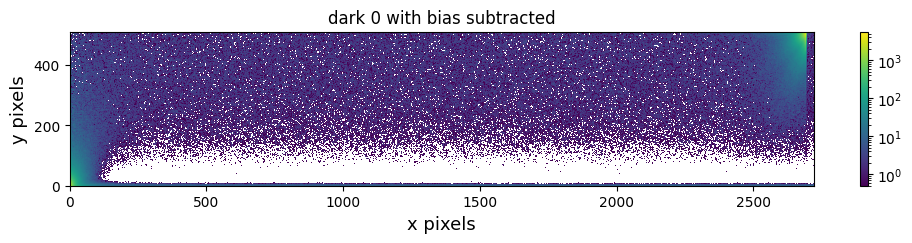

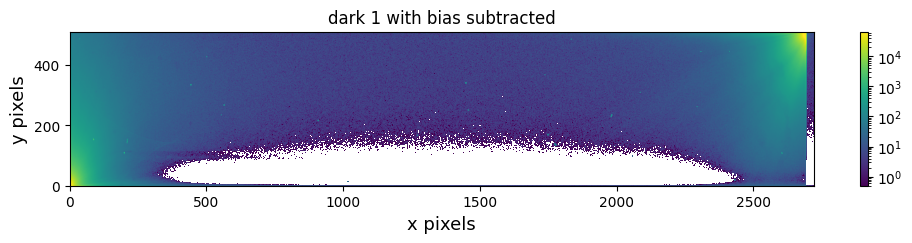

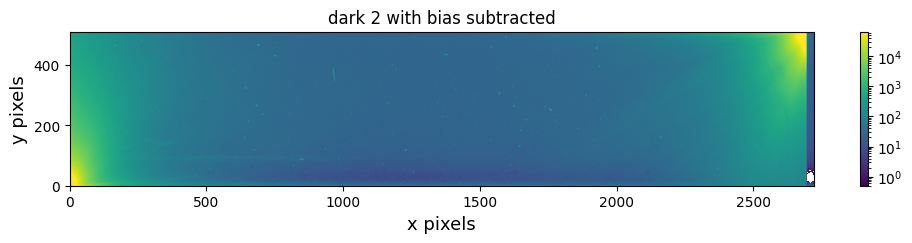

In [28]:
for i, dark_data_file in enumerate(dark_data):
    plot_fits(
        dark_data[i], vmin=None, vmax=None, title=f'dark {i} with bias subtracted', norm='log'
              )

Clearly, the dark frames differ for varying amounts of exposure, whcih makes sense since longer exposure times should lead to increased thermal noise. This is exactly what we see above. For the first dark frame, there is a small amount of what looks like signal, but is really thermal noise, where as for the final dark freme, the majority of the data is an order of magnitude brighter than the other plots.

In [30]:
#subtracting the correct dark frame (number 3 ~ index num 2) from the source and calibration file
source_dark_adj = source_data - dark_data[2] #the source file with dark subtracted
cal_dark_adj = calibration_data - dark_data[2] #the calibration file with dark subtracted

### Part 2.3 - Master Flat

We once again would like to produce the median of all the flat frames, though this time, we would like to eliminate all of the flat frames that have significant saturation. Examining the header of one of the flats, we see that the max value for one pixel is 65535 (16 bits) meaning we can say that if a pixel value is at this value then it must be over saturated. Setting a 1% limit on the max amount of pixels that are allowed to be saturated we find that several plots are over saturated.

In [31]:
#shows 16 bits per pixel
print(repr(flat_files[0][0].header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'flat    '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =                 5.00  / Temps d'exposition (sec)                      
DARKTIME=                 5.00  / Temps total ecoule (sec)                      
IMAGETYP= 'dflat   '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T09:44:

In [32]:
saturation_value = 65535 - 32768  # Maximum physical value for a 16-bit frame with BZERO=32768 (adjusted for bias subtraction)
saturation_fraction_threshold = 0.01  # e.g., 1%

good_frames = []
for idx, frame in enumerate(flat_data):
    num_saturated = np.sum(frame >= saturation_value)
    total_pixels = frame.size
    frac_saturated = num_saturated / total_pixels

    if frac_saturated <= saturation_fraction_threshold:
        good_frames.append(frame)
        print(f"Frame {idx} has sufficiently low saturation.")
    else:
        print(f"Frame {idx} rejected: {frac_saturated:.2%} pixels are saturated.")

Frame 0 has sufficiently low saturation.
Frame 1 rejected: 34.46% pixels are saturated.
Frame 2 has sufficiently low saturation.
Frame 3 has sufficiently low saturation.
Frame 4 rejected: 34.67% pixels are saturated.
Frame 5 has sufficiently low saturation.
Frame 6 rejected: 34.58% pixels are saturated.
Frame 7 rejected: 34.67% pixels are saturated.
Frame 8 rejected: 34.69% pixels are saturated.
Frame 9 has sufficiently low saturation.
Frame 10 has sufficiently low saturation.
Frame 11 has sufficiently low saturation.
Frame 12 has sufficiently low saturation.
Frame 13 rejected: 34.63% pixels are saturated.
Frame 14 rejected: 34.57% pixels are saturated.
Frame 15 rejected: 34.44% pixels are saturated.
Frame 16 has sufficiently low saturation.
Frame 17 rejected: 34.66% pixels are saturated.
Frame 18 rejected: 34.53% pixels are saturated.
Frame 19 has sufficiently low saturation.
Frame 20 has sufficiently low saturation.
Frame 21 has sufficiently low saturation.
Frame 22 rejected: 24.86% 

In [33]:
#gathering all usable flats into an  array based on the output directly above
usable_flats_idxs = np.array([0, 2, 3, 5, 9, 10, 11, 12, 16, 19, 20, 21])

It is worth noting that we could have found the same thing by comparing (by eye) the images with and without significant saturation. For example...

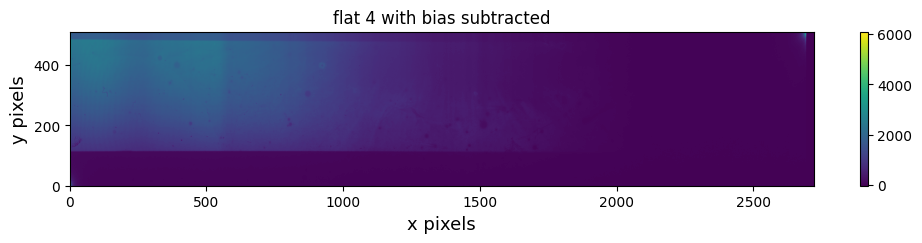

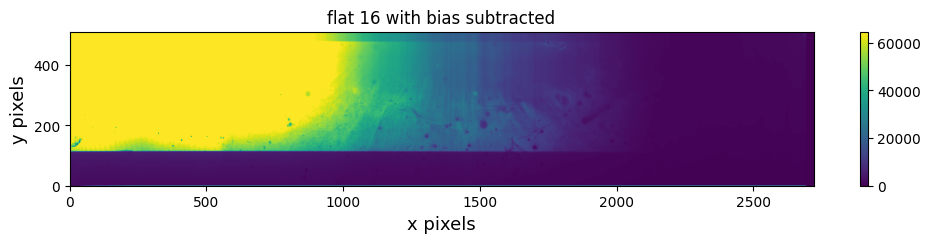

In [34]:
vmin=None
vmax=None
norm=None

#uncomment if want to plot all of the flats with bias subtracted
# for i, flat in enumerate(flat_data):
#     plot_fits(
#         flat, vmin=None, vmax=None, title=f'flat {i} with bias subtracted', norm=norm
#               )

#One example of good and too much saturation respectively
plot_fits(
    flat_data[3], vmin=None, vmax=None, title='flat 4 with bias subtracted', norm=norm
          )
plot_fits(
    flat_data[15], vmin=None, vmax=None, title='flat 16 with bias subtracted', norm=norm
          )

Now to create the master flat

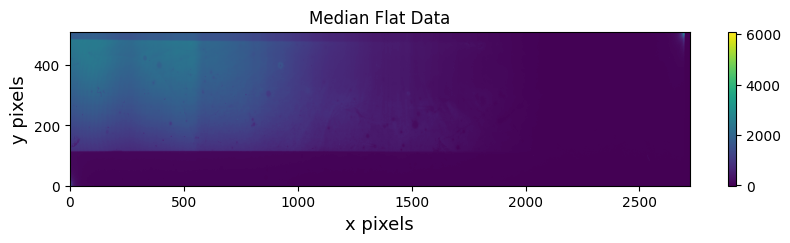

In [38]:
#indices of flats without significant saturation:
usable_flats_idxs = np.array([0, 2, 3, 5, 9, 10, 11, 12, 16, 19, 20, 21])

#Now get the median of the usable flats
flat_data = np.array(flat_data)
# print(flat_data.shape)
# print(np.median(flat_data, axis = 0).shape)
median_flat_data = np.median(flat_data, axis = 0)

#make a quick plot to again see what we're dealing with
plot_fits(
    median_flat_data, vmin=None, vmax=None, title='Median Flat Data', norm=None
          )

Since a flat frame attempts to correct for instrumental effects and variations in the signal across the detector, it makes sense that they would be an observation of a uniformly illuminated plane by the telescope. Any pixel to pixel variation caused by the instrument or unaccounted for variations in the light path through the telescope may introduce spectral structure. It seems there are several instances of dark spots along the color gradient "strip" that is going from light blue to purple (going from left to right) in the 2D median flat frame. These could be the result of pixel to pixel sensitivety variation in the detector caused by each pixel responding to the incoming light slighly differently. By dividing by this frame, our goal is to "normalize" the final cleaned frame such that the intensity of the light is the true intensity of the source and not that caused by detector inconsistencies.

/tmp/ipykernel_1700273/1297400204.py:3: RuntimeWarning: divide by zero encountered in divide
  source_darkflat_adj = (source_dark_adj)/(median_flat_data) #source divided by flat
/tmp/ipykernel_1700273/1297400204.py:3: RuntimeWarning: invalid value encountered in divide
  source_darkflat_adj = (source_dark_adj)/(median_flat_data) #source divided by flat
/tmp/ipykernel_1700273/1297400204.py:4: RuntimeWarning: divide by zero encountered in divide
  cal_darkflat_adj = (cal_dark_adj)/(median_flat_data) #calibration divided by flat
/tmp/ipykernel_1700273/1297400204.py:4: RuntimeWarning: invalid value encountered in divide
  cal_darkflat_adj = (cal_dark_adj)/(median_flat_data) #calibration divided by flat


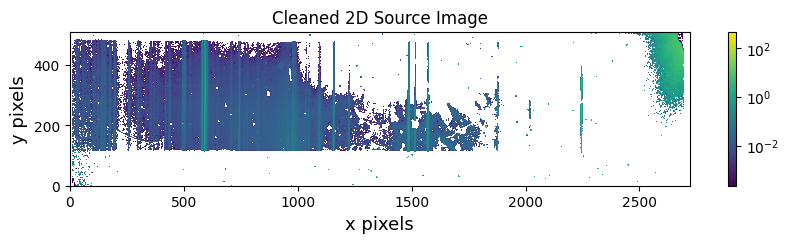

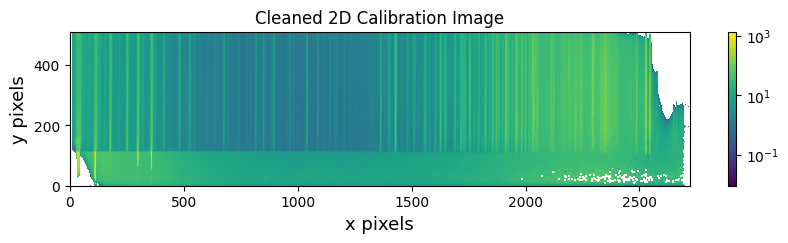

In [79]:
#adjusting for (dividing by) the flat data:
plt.rcParams['figure.figsize'] = (10, 2)
source_darkflat_adj = (source_dark_adj)/(median_flat_data) #source divided by flat
cal_darkflat_adj = (cal_dark_adj)/(median_flat_data) #calibration divided by flat
# norm = SymLogNorm(linthresh=0.03)
norm = 'log'

plot_fits(
    source_darkflat_adj, vmin=None, vmax=None, title='Cleaned 2D Source Image', norm=norm
          )
plot_fits(
    cal_darkflat_adj, vmin=None, vmax=None, title='Cleaned 2D Calibration Image', norm=norm
          )

Compared to pre-cleaning, the source image almost looks 'worse' than before. However, there seems to be a large amount of what was likely noise in the original image located along the bottom strip and in between various spectral lines that is no longer present in the source image. Furthermore, there now seems to be far more spectral lines present in the source image that initially when visualizing in the exploration phase. The calibration image has retained much of its spectral structure, though the oversaturation (likely a result of thermal noise) in the top right and lower left corner of the plot now seems to be removed for the most part.

## Part 3 - Wavelength Calibration

During the first stage, we found the ideal region (which was mostly free of thermal noise) to be in the vertical range of about 180 - 200 pixels. Additionally, trimming the horizontal axes to better reflect the data and not the noise, we can visualize our now cleaned source and calibration data spectra.

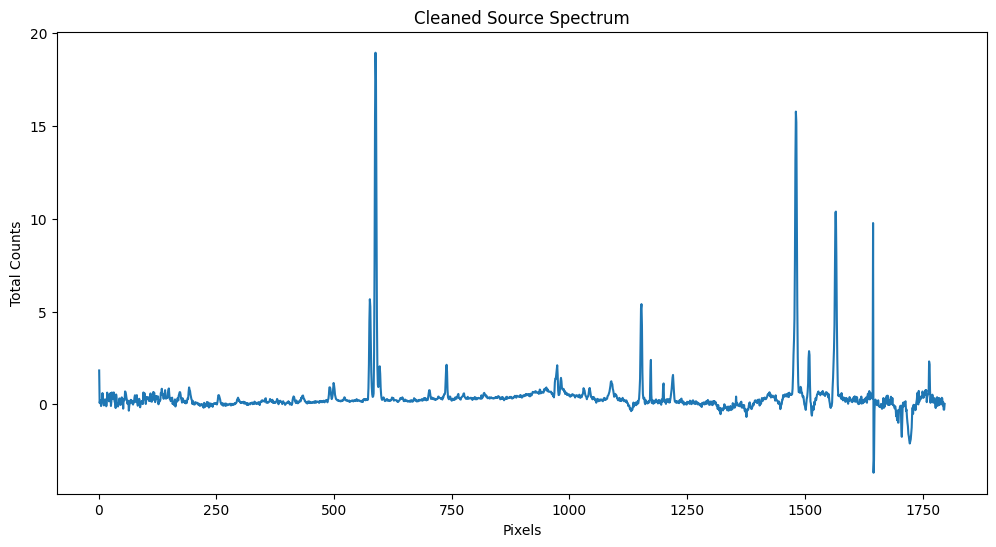

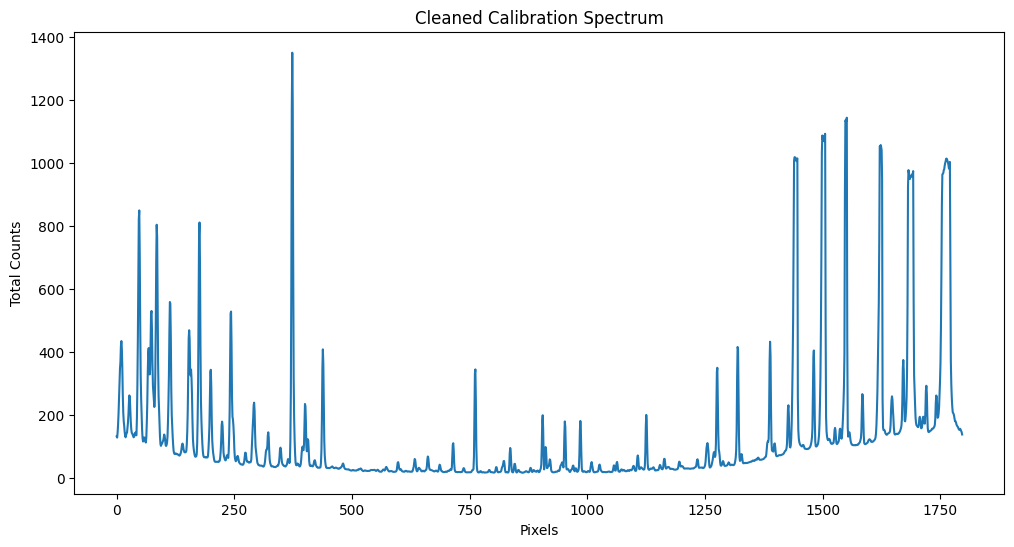

In [40]:
cleaned_source_spectrum = np.sum(source_darkflat_adj[180:200, 2:1800], axis = 0)
plt.rcParams['figure.figsize'] = (12, 6)
cleaned_cal_spectrum = np.sum(cal_darkflat_adj[180:200, 2:1800], axis=0)

#Anticipating the next section, I plot the calibration file reversed here, since this is what is needed to match to the cuar file
cleaned_cal_spectrum = cleaned_cal_spectrum[::-1]

plt.plot(cleaned_source_spectrum)
plt.title('Cleaned Source Spectrum')
plt.xlabel('Pixels')
plt.ylabel('Total Counts')
plt.show()
plt.plot(cleaned_cal_spectrum)
plt.title('Cleaned Calibration Spectrum')
plt.xlabel('Pixels')
plt.ylabel('Total Counts')
plt.show()

The cleaned calibration 1D image shows many discernable peaks (far more in fact than the source 1D image). It is also worth noting that many of the peaks on the right hand side as plotted above have "flat" tops to them meaning they are likely oversaturated and we are not seeing the full peak.

#### Matching peaks from the CuAr lamp to the calibration file

The next step is to matche the peaks of the CuAr lamp file to the peaks of the calibration spectrum.

Plotting the CuAr file, we see the rather unhelpful looking spectum.

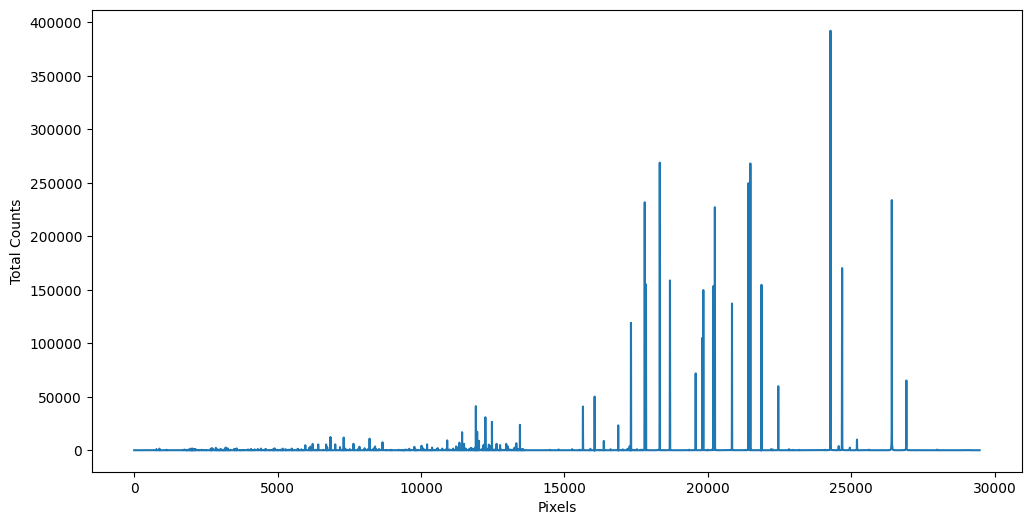

In [43]:
cuar_file_path = './fit_files/cuar.fits'
cuar_data, cuar_file = fits_to_data(cuar_file_path)

plt.plot(cuar_data)
plt.xlabel('Pixels')
plt.ylabel('Total Counts')
plt.show()

The step to make this process easier is to conver the x axis of the cuar spectrum to units of wavelength. We can do this using astropy and the information from the HDUL header.


In [47]:
#we could just run this if wanting to find the wavelength value of just one pixel.
filename = './fit_files/cuar.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header  # Assuming the WCS is in the primary header
    # Create a WCS object from the header
    wcs = WCS(header)

#Eg.. What is the wavelength value of pixel number 25000..?
pixel_index = 25000
pixels = np.array([[pixel_index]])  # 2D array with one coordinate pair
wavelength = wcs.all_pix2world(pixels, 0)

print(f"Pixel {pixel_index} corresponds to a wavelength of {wavelength[0, 0]:.3f} Angstroms")


Pixel 25000 corresponds to a wavelength of 9303.565 Angstroms


In [48]:
#Or... we could convert the whole axis to wavelengths at once
npix = header['NAXIS1']

#Create an array of pixel indices.
pixel_indices = np.arange(npix)[:, np.newaxis]

#Convert all pixel indices to world coordinates (wavelengths)
wavelengths = wcs.all_pix2world(pixel_indices, 0)  # returns an array of shape (npix, 1)

#Flatten the result to get a 1D array of wavelengths
wavelengths = wavelengths.flatten()

#Attach units as Angstroms
wavelengths = wavelengths * u.Angstrom

print(wavelengths)

[ 3053.56518555  3053.81518555  3054.06518555 ... 10422.81518555
 10423.06518555 10423.31518555] Angstrom


The cuar file can now be plotted in units of wavelengths.

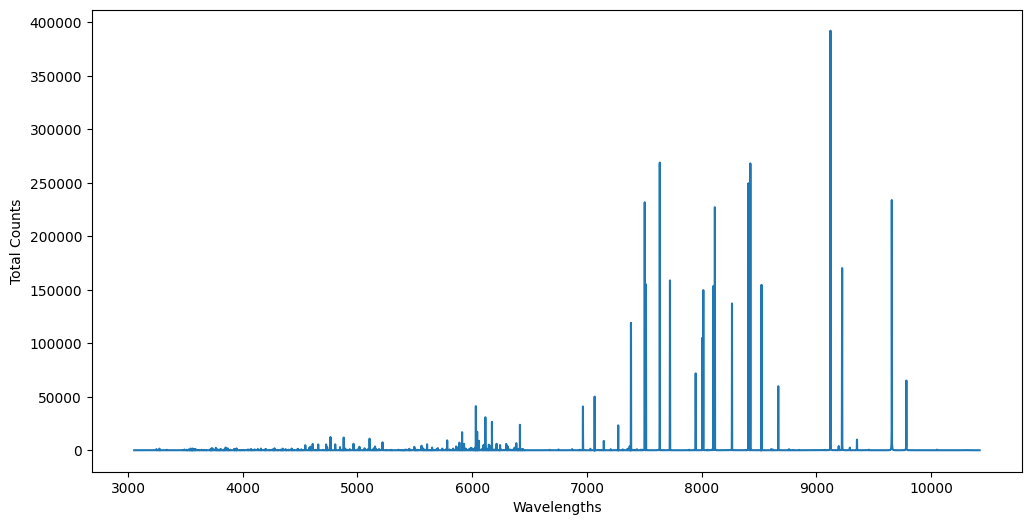

In [50]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(wavelengths, cuar_data)
plt.xlabel('Wavelengths')
plt.ylabel('Total Counts')
plt.show()

We can proceed by writing a function to pick out peaks, lay the to images over top of one another to match the peaks and manually record the wavelength, pixel pairs.

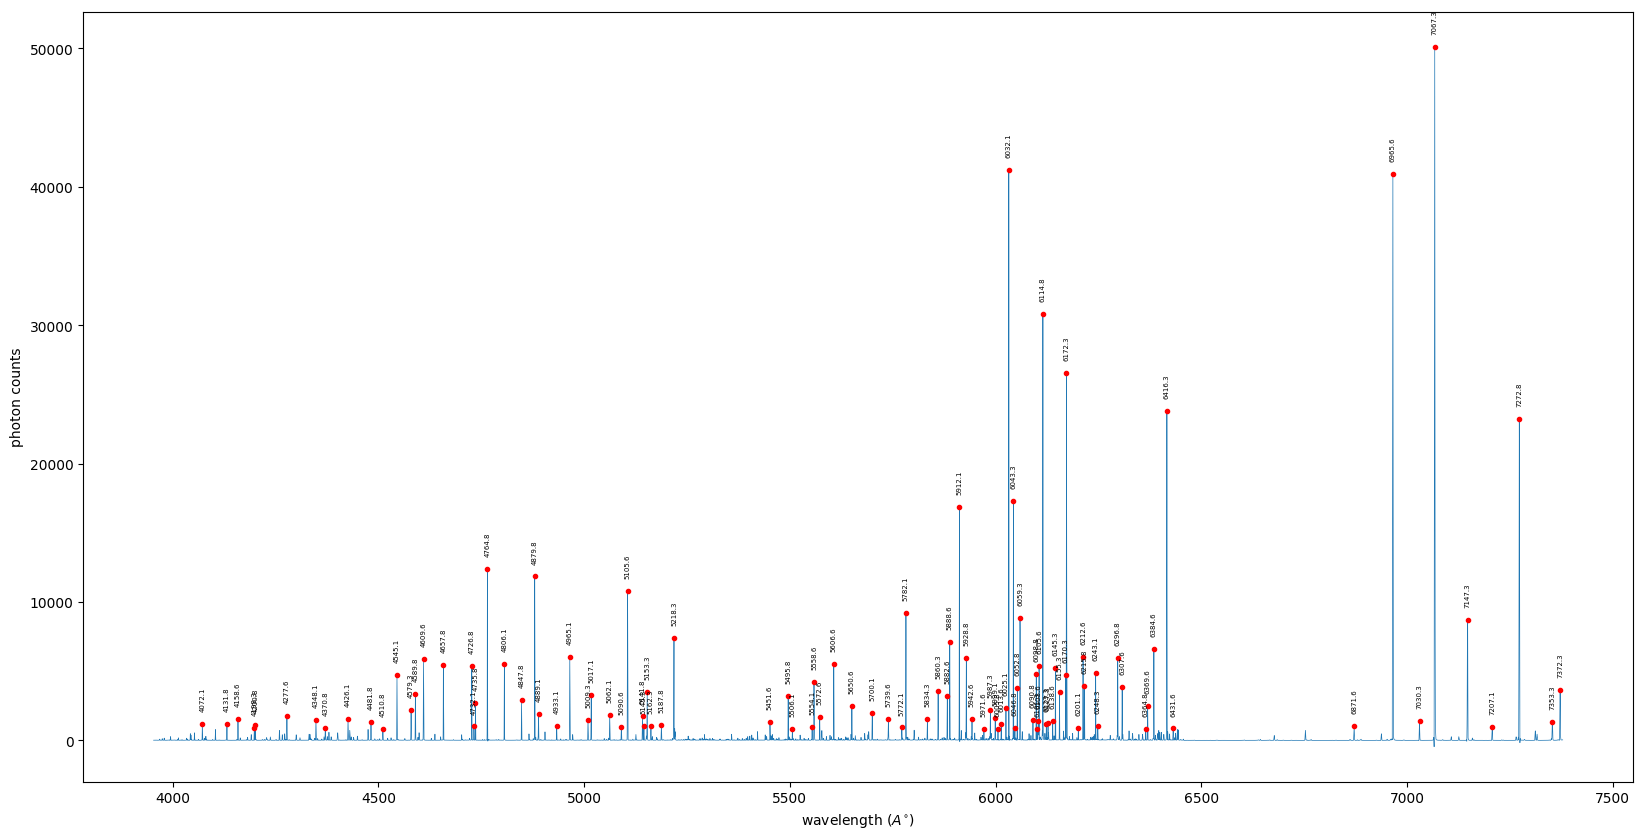

In [54]:
plt.rcParams['figure.figsize'] = (20, 10)

#choose and xmin and xmax that reflect the range of peaks in the calibration file
xmin = 3600
xmax = 17300
cuar_data2 = cuar_data[xmin:xmax]
wavelengths_segment = wavelengths[xmin:xmax]

#find the indices and values of the relative extrema
cuar_idxs = argrelextrema(cuar_data2, np.greater, order=5)[0]
max_cuar_vals = cuar_data[cuar_idxs]

#only choose those greater than a certain threshold number
rel_max_cuar_idxs = cuar_idxs[cuar_data2[cuar_idxs] > 800]
peak_wavelengths = np.array(wavelengths_segment[rel_max_cuar_idxs])
peak_intensities = np.array(cuar_data2[rel_max_cuar_idxs])
# print(peak_wavelengths)
# print(peak_intensities)

plt.plot(wavelengths_segment, cuar_data2, linewidth=0.5)
plt.plot(peak_wavelengths, peak_intensities,'.', color = 'red')
plt.xlabel('wavelength ($A^{\circ}$)')
plt.ylabel('photon counts')
for i, wavelength in enumerate(peak_wavelengths):
    plt.annotate(f"{peak_wavelengths[i]:.1f}", (peak_wavelengths[i], peak_intensities[i]),
                 textcoords='offset points', xytext=(0,10), ha='center', rotation=90, fontsize=5)

#Easiest to save the fig to be able to compare images in a blank powerpoint file
# plt.savefig('cuar_display_peaks.png', dpi=800, format='png', bbox_inches='tight')

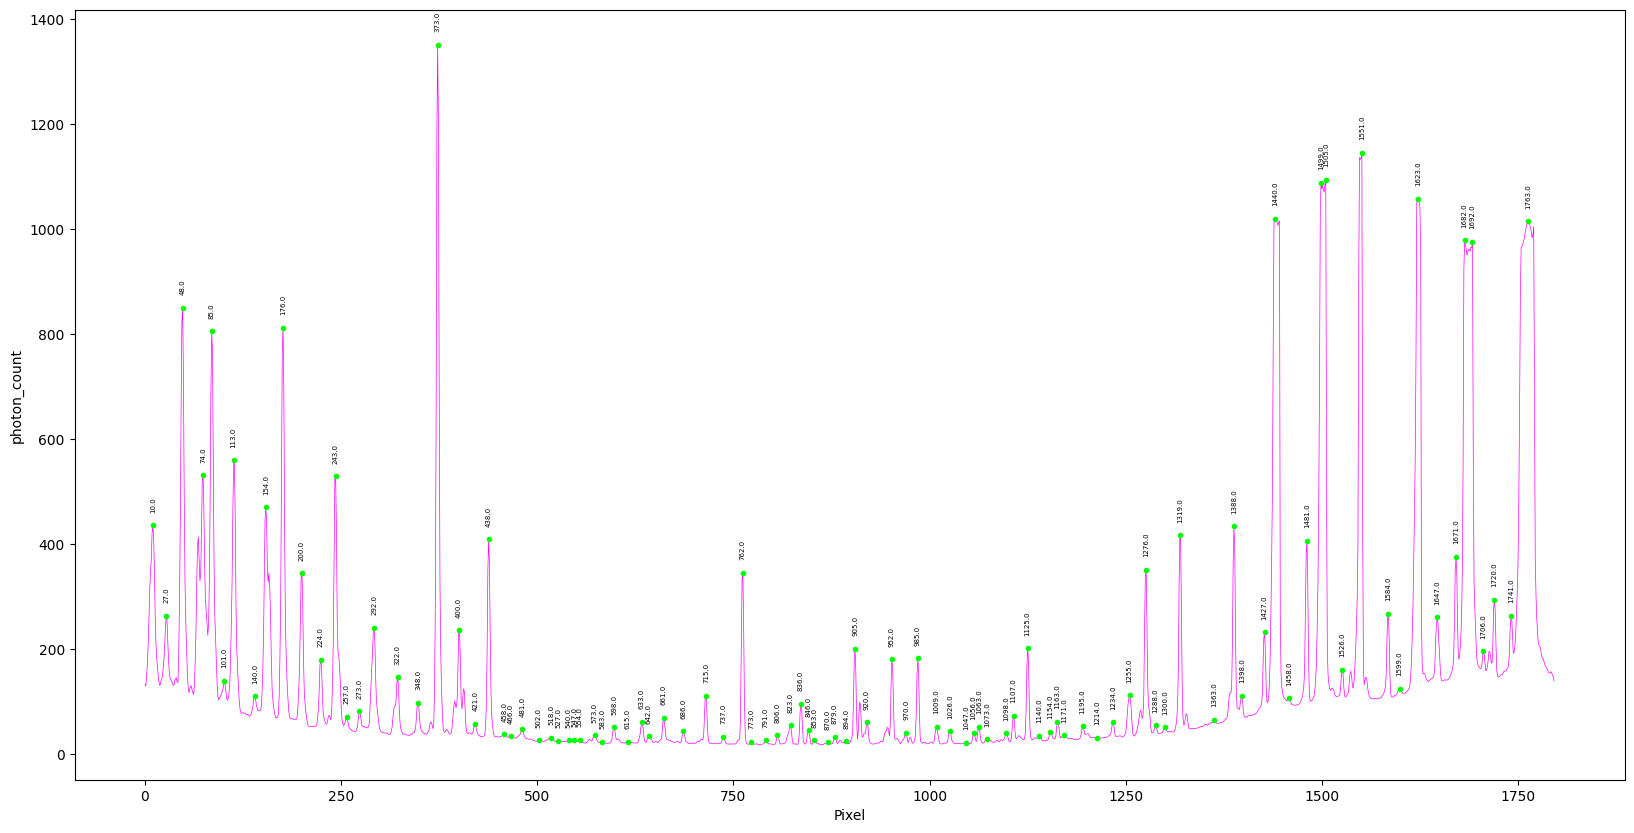

In [56]:
#repeat for the calibration file
calibration_idxs = argrelextrema(cleaned_cal_spectrum, np.greater, order=5)[0]
max_cal_vals = cleaned_cal_spectrum[calibration_idxs]

plt.plot(cleaned_cal_spectrum, color = 'magenta', linewidth=0.5)
plt.plot(calibration_idxs, max_cal_vals,'.', color = 'lime')
plt.xlabel('Pixel')
plt.ylabel('photon_count')
for i, idx in enumerate(calibration_idxs):
    plt.annotate(f"{calibration_idxs[i]:.1f}", (calibration_idxs[i], max_cal_vals[i]),
                 textcoords='offset points', xytext=(0,10), ha='center', rotation=90, fontsize=5)

# plt.savefig('calibration_with_peaks.png', dpi=800, format='png', bbox_inches='tight')

Matching was done using PowerPoint by dragging one image onto the other and locating the matching peaks.

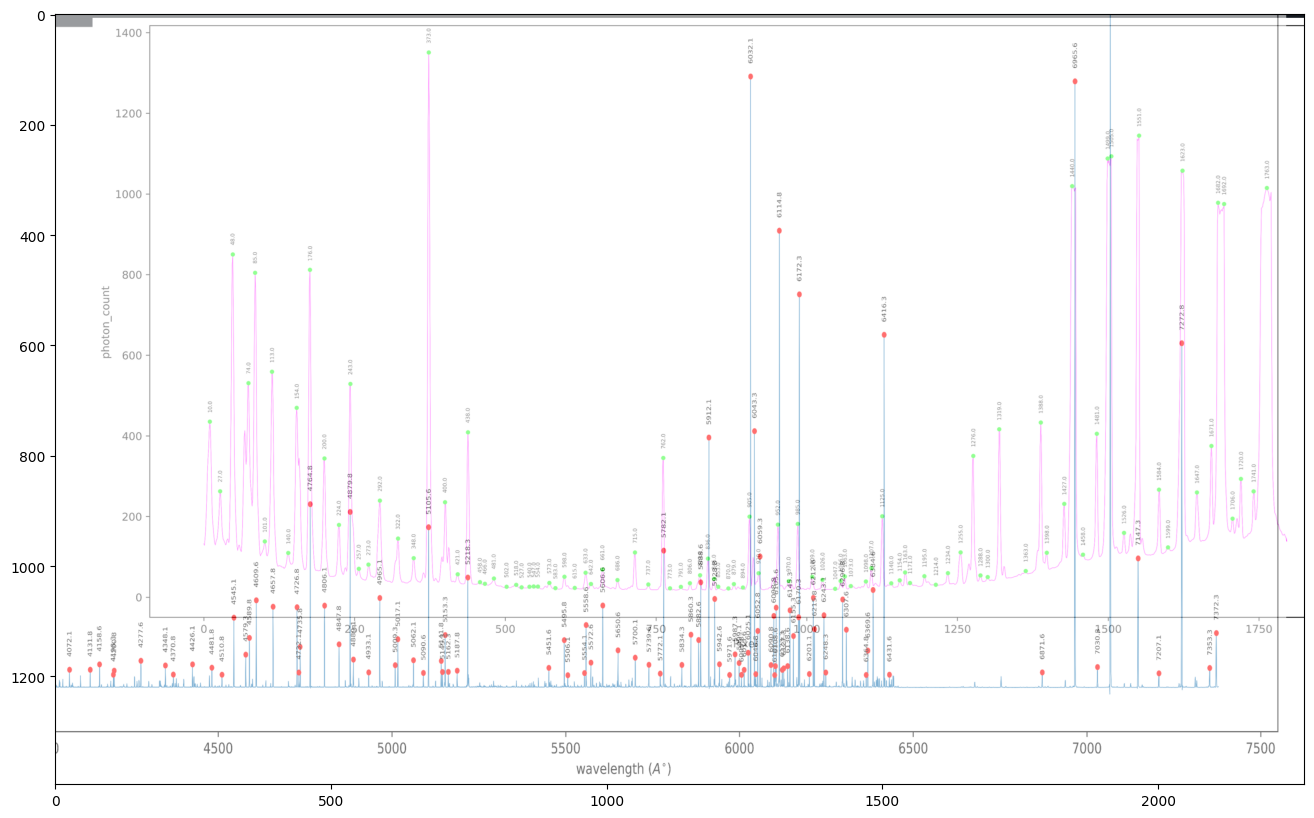

In [57]:
import matplotlib.image as mpimg
cal_by_eye_img = mpimg.imread('calbyeye2.png')
plt.imshow(cal_by_eye_img)
plt.show()

In [59]:
#adding to each array by comparing the two plots by eye (the ordering goes from left to right)

#Manual wavelength pixel pairs
cuar_peaks = np.array(
    [4545.1, 4609.6, 4657.8, 4726.8, 4764.8, 4806.1, 4847.8, 4879.8, 4933.1, 4965.1, 5017.1, 5062, 5105.6, 5218.3,
     5496.8, 5558.6, 5606.6, 5650.6, 5700.1, 5739.6, 5782.1, 5912.1, 6032.1, 6059.3, 6114.8, 6172.3, 6243.1, 6384.6,
     6416.3, 6871.6, 6965.6, 7030.8, 7147.3, 7207.1, 7272.8, 7353.3, 7372.3])
calibration_peaks = np.array(
    [48, 85, 113, 154, 176, 200, 224, 243, 273, 292, 322, 348, 373, 438, 598, 633, 661, 686, 715, 737, 762, 836, 905,
     920, 952, 985, 1026, 1107, 1125, 1388, 1440, 1481, 1551, 1584, 1623, 1671, 1687])

At first pass to fitting, we can try to fit the wavelength - pixel relationship using a linear curve.

In [69]:
def fit_fun(x, m, b):
    return m*x + b

fitp, cov = curve_fit(fit_fun, calibration_peaks, cuar_peaks)
residuals = cuar_peaks - fit_fun(calibration_peaks, fitp[0], fitp[1])

Text(0, 0.5, 'Wavelength')

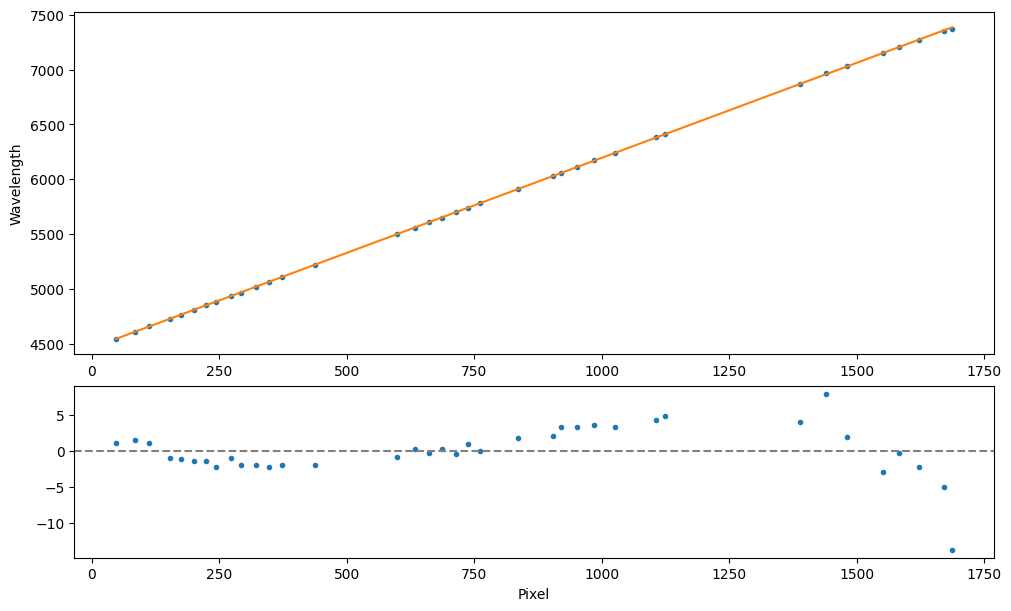

In [71]:
plt.rcParams['figure.figsize'] = (10, 6)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, layout='constrained')
ax1.plot(calibration_peaks, cuar_peaks, '.')
ax1.plot(calibration_peaks, fit_fun(calibration_peaks, fitp[0], fitp[1]))
ax2.plot(calibration_peaks, residuals, '.')
ax2.axhline(y=0, color='grey', linestyle='--')
ax2.set_xlabel('Pixel')
ax1.set_ylabel('Wavelength')

However, it is clear from examining the residuals that there is some non-linear structure in the relationship between pixel and wavelength. Due to the oscillations, we instead choose to fit using a ChebyShev fit. Through examining the effects of different degrees, it seems that a Chebyshev fit of degree 6 is one that represents the data the best, as is seen by the minimal fluctuations in the residuals.

Text(0, 0.5, 'Wavelength')

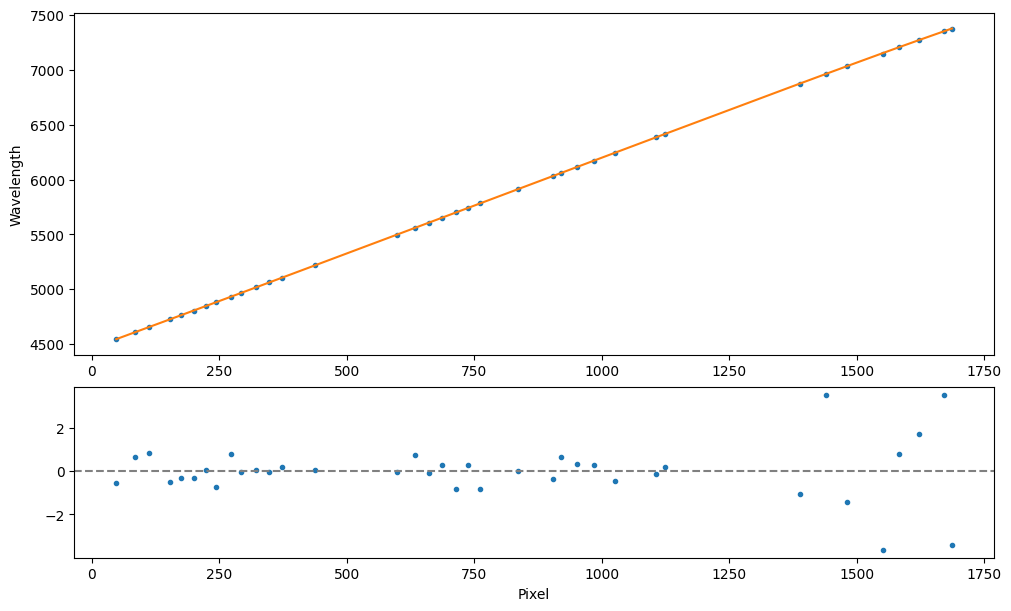

In [72]:
from numpy.polynomial.chebyshev import Chebyshev

#note we can do this quickly using the built in fit function in Numpy
#order 6 seems to give the best fit
cheb_fit = Chebyshev.fit(calibration_peaks, cuar_peaks, 6)
cheb_fit_vals = cheb_fit(calibration_peaks)
cheb_residuals = cuar_peaks - cheb_fit_vals


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, layout='constrained')
ax1.plot(calibration_peaks, cuar_peaks, '.')
ax1.plot(calibration_peaks, cheb_fit_vals)
ax2.plot(calibration_peaks, cheb_residuals, '.')
ax2.axhline(y=0, color='grey', linestyle='--')
ax2.set_xlabel('Pixel')
ax1.set_ylabel('Wavelength')

The problem with peforming the fit this way, however, is we lose the straightforward ability to produce a covariance matrix. Instead, if we again use Scipy's curve_fit, we can easily retrieve the covariance. The error can be found using the corresponding Chebyshev basis functions. This is done in the cell below.

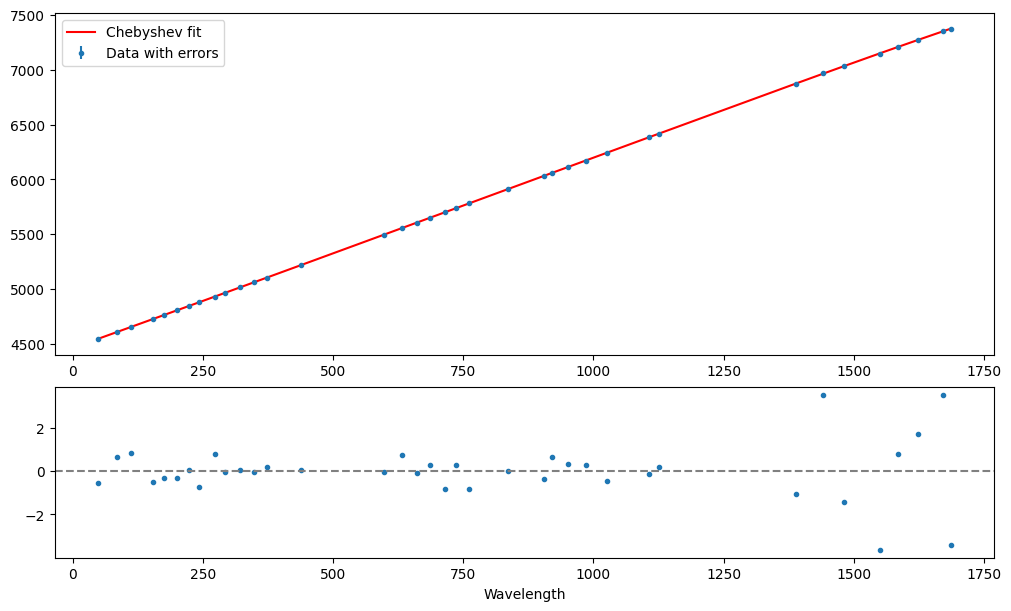

Optimal coefficients: [ 4.46356809e+03  1.70876802e+00  6.96282840e-06  2.47857652e-08
 -2.17651765e-11  7.18652170e-15 -8.77184560e-19]
Covariance matrix:
 [[ 5.74306474e+00 -8.15662368e-02  1.87775134e-04 -1.91200691e-07
   9.55949935e-11 -2.29939448e-14  2.12596827e-18]
 [-8.15662368e-02  1.32109037e-03 -3.25074928e-06  3.43560649e-09
  -1.75807105e-12  4.29537777e-16 -4.01579381e-20]
 [ 1.87775134e-04 -3.25074928e-06  8.34682902e-09 -9.05781968e-12
   4.71805767e-15 -1.16734644e-18  1.10160601e-22]
 [-1.91200691e-07  3.43560649e-09 -9.05781968e-12  1.00104382e-14
  -5.28407884e-18  1.32057145e-21 -1.25593841e-25]
 [ 9.55949935e-11 -1.75807105e-12  4.71805767e-15 -5.28407884e-18
   2.81808677e-21 -7.10007215e-25  6.79650930e-29]
 [-2.29939448e-14  4.29537777e-16 -1.16734644e-18  1.32057145e-21
  -7.10007215e-25  1.80063004e-28 -1.73297139e-32]
 [ 2.12596827e-18 -4.01579381e-20  1.10160601e-22 -1.25593841e-25
   6.79650930e-29 -1.73297139e-32  1.67542338e-36]]


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.polynomial.chebyshev import chebval, chebvander

#Define the Chebyshev model function.
#The function takes x and an arbitrary number of coefficients.
def chebyshev_model(x, *coeffs):
    return chebval(x, coeffs)

#Set the polynomial degree (for degree 6, we need 7 coefficients) => We know degree 6 works the best from above
degree = 6
n_params = degree + 1

#Provide an initial guess for the parameters (here, just ones)
p0 = np.ones(n_params)

#Use curve_fit to fit the Chebyshev model.
popt, pcov = curve_fit(chebyshev_model, calibration_peaks, cuar_peaks, p0=p0)

#popt are the optimal coefficients; pcov is their covariance matrix.
#Evaluate the fitted model at the calibration peaks.
cheb_fit_vals = chebyshev_model(calibration_peaks, *popt)

#To propagate the covariance into errors on the fitted values:
#For a model f(x) = sum_i c_i * T_i(x), the partial derivative with respect to c_i is T_i(x).
#We can compute the Chebyshev Vandermonde matrix, which gives the basis functions at each x.
V = chebvander(calibration_peaks, degree)  # shape (N, n_params)

#The error (standard deviation) on f(x) at each x is then:
#sigma_f(x) = sqrt( v(x)^T * pcov * v(x) )
#We compute this vectorized over all x.
fit_errors = np.sqrt(np.sum(V * (V @ pcov), axis=1))

#Plot the data, the fitted Chebyshev polynomial, and error bars on the fit.
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, layout='constrained')

#Top plot: data with fitted curve and error bars.
ax1.errorbar(calibration_peaks, cuar_peaks, yerr=fit_errors, fmt='.', label='Data with errors')
ax1.plot(calibration_peaks, cheb_fit_vals, 'r-', label='Chebyshev fit')
ax1.legend()

#Bottom plot: residuals.
cheb_residuals = cuar_peaks - cheb_fit_vals
ax2.plot(calibration_peaks, cheb_residuals, '.')
ax2.axhline(y=0, color='grey', linestyle='--')
ax2.set_xlabel('Wavelength')

plt.show()

# Optionally, print the fit parameters and covariance:
print("Optimal coefficients:", popt)
print("Covariance matrix:\n", pcov)


## Investigation + Putting it all Together

#### Converting the cleaned data array into a 1D spectrum (ie. a function of wavelength)

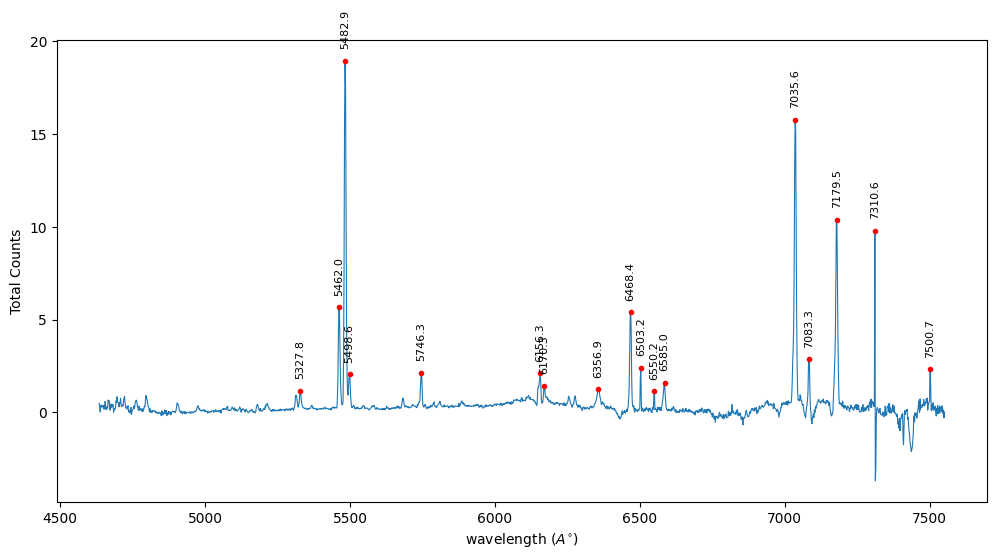

In [78]:
plt.rcParams['figure.figsize'] = (12, 6)

#pltting the cleaned source spectrum in the same y ranges as initially and in the x ranges that allow us to clearly see the defining spectral features
xmin=100
xmax=1800
cleaned_source_spectrum = np.sum(source_darkflat_adj[180:200, xmin:xmax], axis = 0)

#converting pixel values to wavelength:
pixel_array = np.arange(xmin, len(cleaned_source_spectrum)+xmin)

# source_wavelength_array = chebyshev_model(pixel_array, *popt)
source_wavelength_array = cheb_fit(pixel_array)

#selecting the most prominent peaks on the plot
source_idxs = argrelextrema(cleaned_source_spectrum, np.greater, order=5)[0]
source_vals = cleaned_source_spectrum[source_idxs]
# print(source_idxs.shape)
# print(source_vals.shape)

#pick out the most discernable peaks
max_source_idxs = source_idxs[cleaned_source_spectrum[source_idxs] > 1]
max_source_wavelengths = np.array(source_wavelength_array[max_source_idxs])
max_source_peaks = np.array(cleaned_source_spectrum[max_source_idxs])

plt.plot(source_wavelength_array, cleaned_source_spectrum, linewidth=0.8)
plt.plot(max_source_wavelengths, max_source_peaks, '.', color='red')
plt.xlabel('wavelength ($A^{\circ}$)')
plt.ylabel('Total Counts')
for i, idx in enumerate(max_source_wavelengths):
    plt.annotate(f"{max_source_wavelengths[i]:.1f}", (max_source_wavelengths[i], max_source_peaks[i]),
                 textcoords='offset points', xytext=(0,10), ha='center', rotation=90, fontsize=8)
plt.show()

The most prominent lines present in the final spectrum shown above are a collection around 5482.9 Angstroms, a collection around 6468.3 Angstroms, and one at 7035.5 Angstroms. Each of these lines corresponds with features we may expect when looking at the Orion nebula. For example, taking into account uncertainties present throughout the wavelength calibration process, the 6468 Angstrom line is very close to the 656.28 nm H-alpha line. It makes sens we see this line since it is the brightest Hydrogen emission line in the visible spectrum. Additionally, the line at 7035 Angstroms is very close transition lines of Argon which would make sense to see in an ionized region such as the Orion nebula. Finally, the strong spectral line at 5482 Angstroms could correspond to a neutral Oxygen line at around 5577 Angstroms (also known as airglow emission) present due to our own atmosphere.

The largest factor affecting the quality of the results is likely the wavelength calibration process undergone here. Matching the different peaks by eye is very difficult and likely didn't result in the most accurate pixel to wavelength conversion possible. One simple and obvious improvement would be to use a special software that could automate this process and eliminate the human error associated with deriving the pixel to wavelength conversion.

Additionally, the simple noise removal routine could be improved upon by incorporating more advanced background subtraction methods. Though I'm not an expert in this area, I imagine something more akin to foreground subtraction used in 21cm physics could be used to better model the noise characteristics from the sky and the detector to better understand what is needed to be subtracted off.